<h2>Dataset Link</h2>

https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data/data


Age- Age Of The Customer <br>
Employment Type- The Sector In Which Customer Is Employed <br>
GraduateOrNot- Whether The Customer Is College Graduate Or Not <br>
AnnualIncome- The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees] <br>
FamilyMembers- Number Of Members In Customer's Family <br>
ChronicDisease- Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc. <br>
FrequentFlyer- Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019]. <br>
EverTravelledAbroad- Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services] <br>
TravelInsurance- Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019. (0: No, 1: Yes)

<h2>Data Preprocessing</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from keras.callbacks import EarlyStopping
import joblib
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_csv('TravelInsurancePrediction.csv', index_col=0)
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [3]:
df.nunique()

,0
Age,11
Employment Type,2
GraduateOrNot,2
AnnualIncome,30
FamilyMembers,8
ChronicDiseases,2
FrequentFlyer,2
EverTravelledAbroad,2
TravelInsurance,2


In [4]:
df.shape

(1987, 9)

In [5]:
df.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


<h2>EDA</h2>

<Axes: xlabel='Age', ylabel='count'>

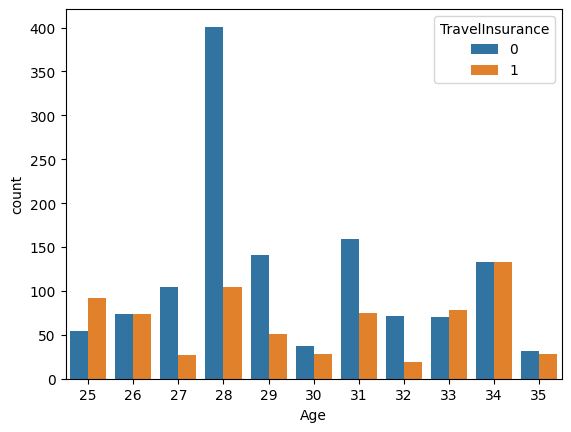

In [7]:
sns.countplot(x='Age', hue='TravelInsurance', data=df)

Across most ages, more people do not buy travel insurance than those who do. <br>
Age of 25 and 33: the number of people who purchase insurance (orange) is relatively high compared to those who don’t.
<br>
Age starting 33 seem split 50/50 in decision-making.

<Axes: xlabel='Employment Type', ylabel='count'>

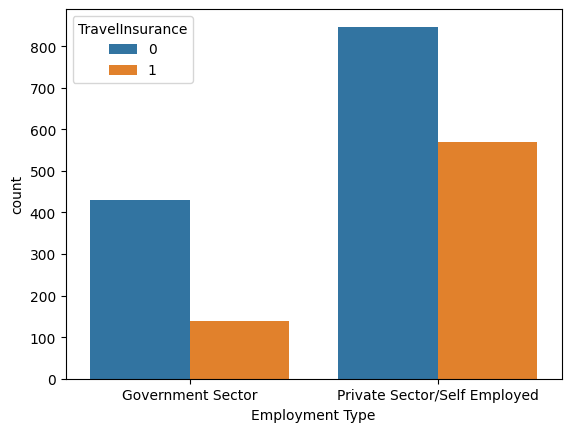

In [8]:
sns.countplot(x='Employment Type', hue='TravelInsurance', data=df)

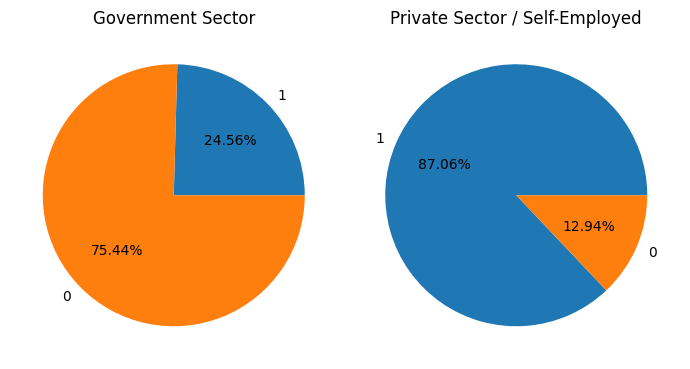

In [9]:
gs_yes = ((df['Employment Type'] == 'Government Sector') & (df['TravelInsurance'] == 1)).sum()
gs_no = ((df['Employment Type'] == 'Government Sector') & (df['TravelInsurance'] == 0)).sum()
ps_yes = ((df['Employment Type'] == 'Private Sector/Self Employed') & (df['TravelInsurance'] == 1)).sum()
ps_no = ((df['Employment Type'] == 'Private Sector/Self Employed') & (df['TravelInsurance'] == 0)).sum()

pct_gs_yes = (gs_yes / (gs_yes + gs_no)) * 100
pct_gs_no = (gs_no / (gs_yes + gs_no)) * 100
pct_ps_yes = (ps_yes / (ps_yes + ps_no)) * 100
pct_ps_no = (ps_no / (ps_yes + ps_no)) * 10

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 5))
labels = ['1', '0']
gov_values = [pct_gs_yes, pct_gs_no]
private_values = [pct_ps_yes, pct_ps_no]

# Government Sector Plot
axes[0].pie(gov_values, labels=labels, autopct='%1.2f%%')
axes[0].set_title('Government Sector')

# Private Sector/Self Employed Plot
axes[1].pie(private_values, labels=labels, autopct='%1.2f%%')
axes[1].set_title('Private Sector / Self-Employed')

plt.tight_layout()
plt.show();

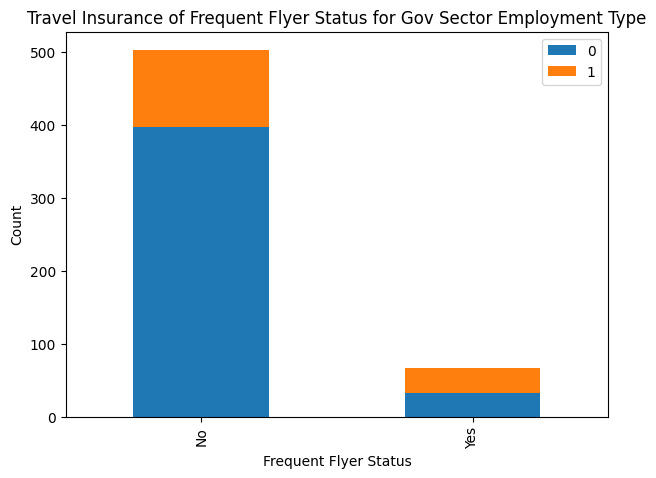

In [10]:
gov_df = df[df['Employment Type'] == 'Government Sector']

# Create a crosstab (counts of TravelInsurance by FrequentFlyer)
crosstab = pd.crosstab(gov_df['FrequentFlyer'], gov_df['TravelInsurance'])

# Plot stacked bar chart
crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(7, 5)
)

plt.title('Travel Insurance of Frequent Flyer Status for Gov Sector Employment Type')
plt.xlabel('Frequent Flyer Status')
plt.ylabel('Count')
plt.legend()
plt.show();

Private/self-employed workers are more likely to purchase travel insurance compared to government workers.

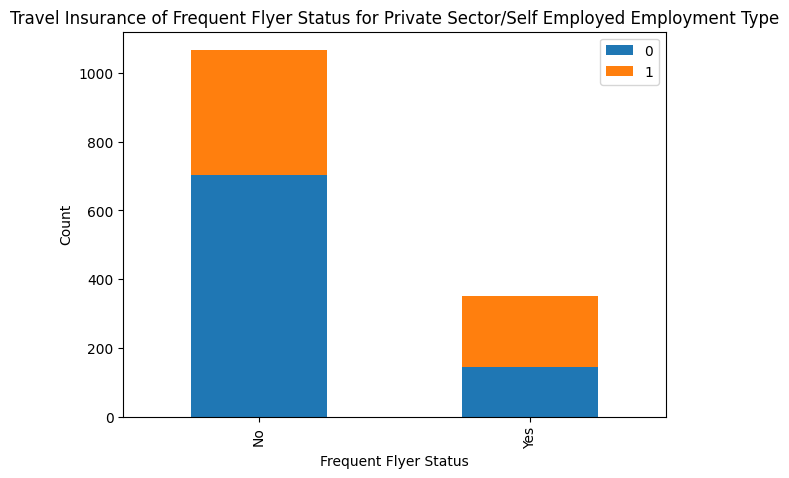

In [11]:
private_df = df[df['Employment Type'] == 'Private Sector/Self Employed']

# Create a crosstab (counts of TravelInsurance by FrequentFlyer)
crosstab = pd.crosstab(private_df['FrequentFlyer'], private_df['TravelInsurance'])

# Plot stacked bar chart
crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(7, 5)
)

plt.title('Travel Insurance of Frequent Flyer Status for Private Sector/Self Employed Employment Type')
plt.xlabel('Frequent Flyer Status')
plt.ylabel('Count')
plt.legend()
plt.show();

Regardless of employment type, frequent flyers are more likely to purchase insurance compared to non-frequent flyers (when looking at proportions, even if their total count is smaller).

<Axes: xlabel='GraduateOrNot', ylabel='count'>

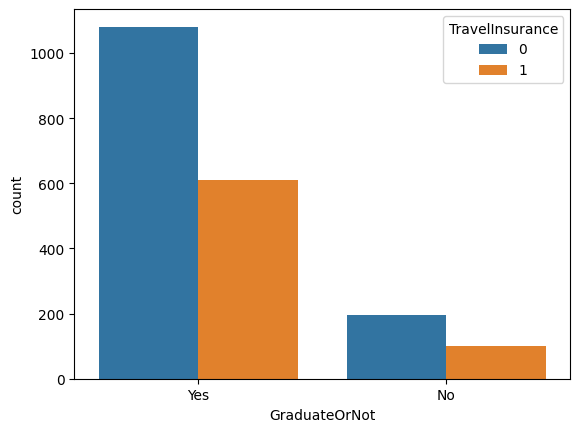

In [12]:
sns.countplot(x='GraduateOrNot', hue='TravelInsurance', data=df)

Graduates slightly more likely to purchase insurance than non-graduates.

<Axes: xlabel='AnnualIncome', ylabel='count'>

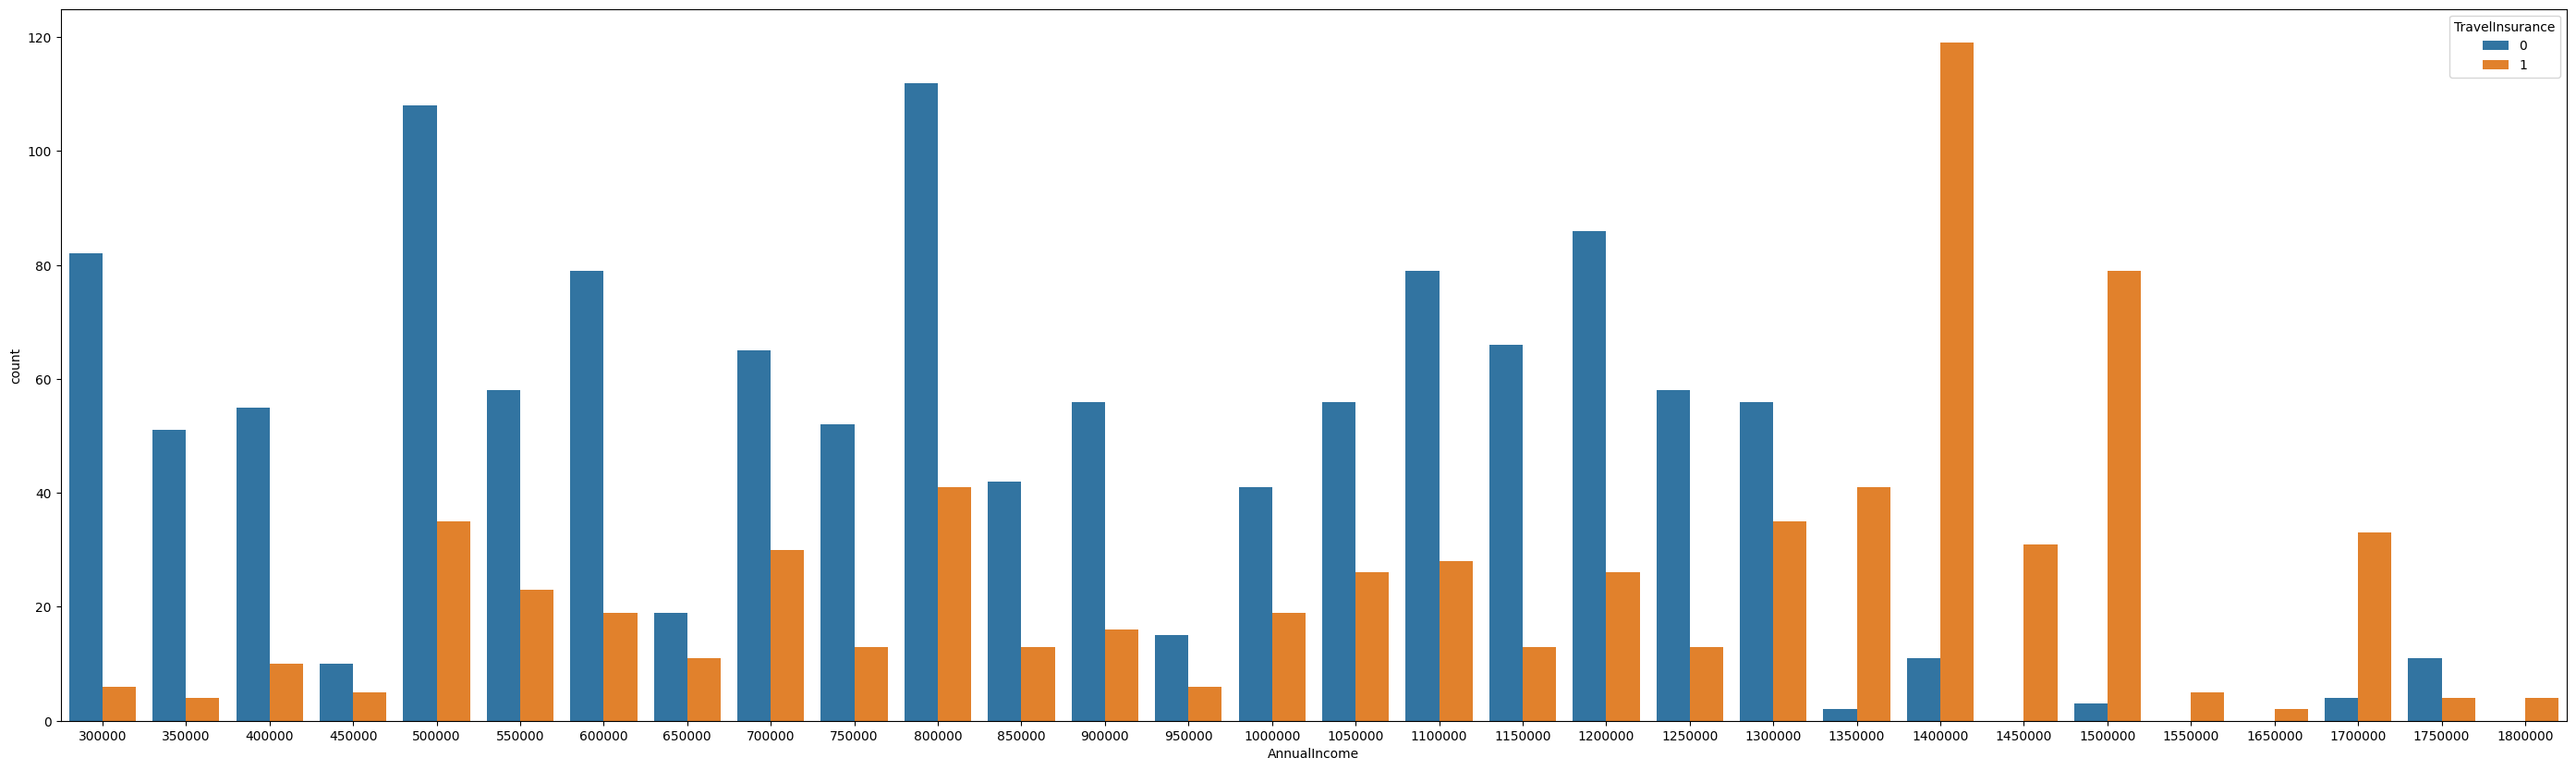

In [13]:
plt.figure(figsize=(35,10))
sns.countplot(x='AnnualIncome', hue='TravelInsurance', data=df)

People with annual income greater than or equal to 13,500,000 tend to purchase travel insurance.

<Axes: xlabel='FamilyMembers', ylabel='count'>

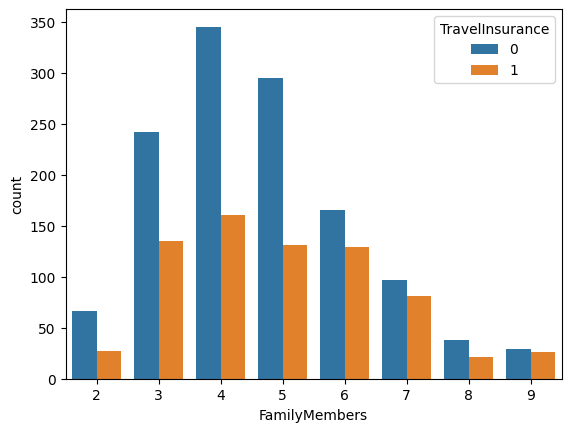

In [14]:
sns.countplot(x='FamilyMembers', hue='TravelInsurance', data=df)

People with family members more than or equal to 6 tend to purchase travel insurance.

<Axes: xlabel='ChronicDiseases', ylabel='count'>

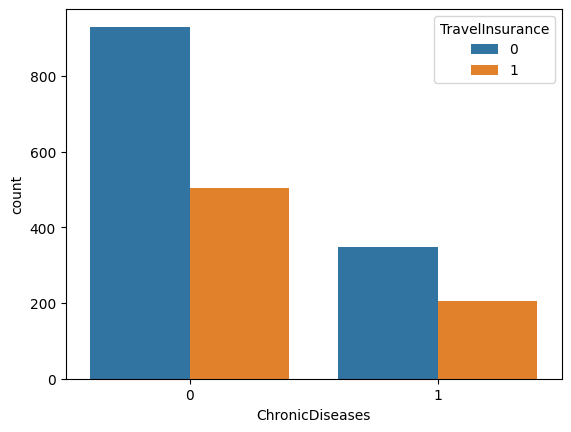

In [15]:
sns.countplot(x='ChronicDiseases', hue='TravelInsurance', data=df)

The probability of people with chronic diaseases in purchasing travel insurance is higher than those with no chronic diaseases.

<Axes: xlabel='EverTravelledAbroad', ylabel='count'>

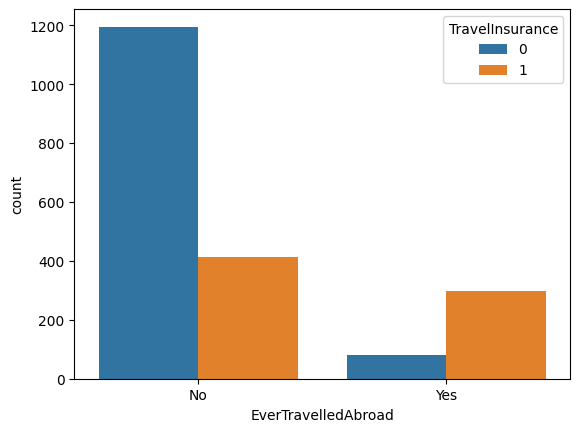

In [16]:
sns.countplot(x='EverTravelledAbroad', hue='TravelInsurance', data=df)

People who used to traveled abroad are more likely to purchase travel insurance compared to those who have not traveled abroad.

In [17]:
df['TravelInsurance'].value_counts()

,count
TravelInsurance,
0,1277
1,710


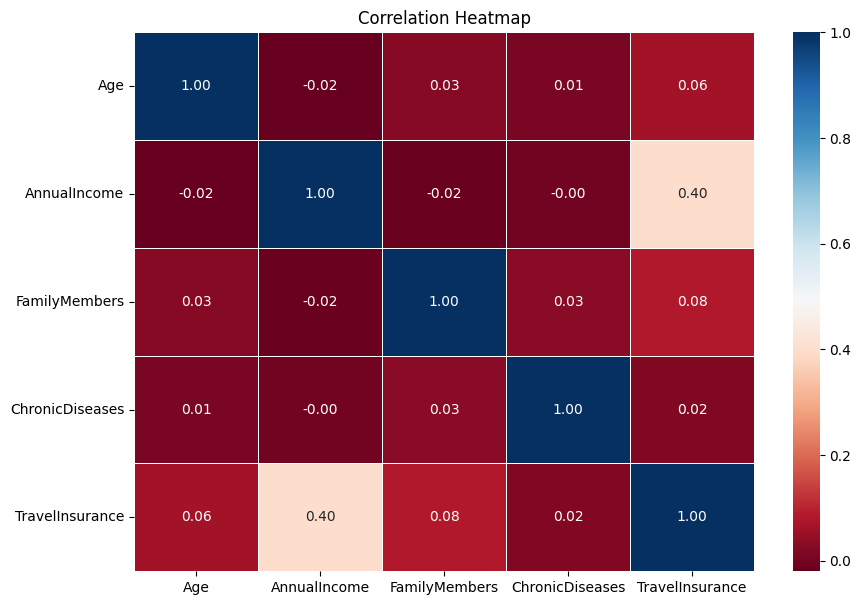

In [18]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show();

<h2>Data Splitting</h2>

In [19]:
x = df.drop('TravelInsurance', axis=1)
y = df['TravelInsurance']
x.shape, y.shape

((1987, 8), (1987,))

In [20]:
x_cat = x.select_dtypes(include='object')
x_num = x.select_dtypes(exclude='object')

le = LabelEncoder()
x_cat = x_cat.apply(le.fit_transform)
x = pd.concat([x_num, x_cat], axis=1)

x.shape, y.shape

((1987, 8), (1987,))

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [22]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

<h2>Machine Learning</h2>

In [23]:
abc = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced'), random_state=42)
abc.fit(x_train, y_train)
acc_train = abc.score(x_train, y_train)

# Make predictions
y_pred = abc.predict(x_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Train Accuracy: {acc_train:.4f}')
print(f'Logistic Regression Test Accuracy: {acc_test:.4f}')

Logistic Regression Train Accuracy: 0.8339
Logistic Regression Test Accuracy: 0.8342


In [24]:
cr_ML = classification_report(y_test, y_pred)
print(cr_ML)

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       257
           1       0.92      0.58      0.71       141

    accuracy                           0.83       398
   macro avg       0.87      0.78      0.80       398
weighted avg       0.85      0.83      0.82       398



In [25]:
cm_ML = confusion_matrix(y_test, y_pred)
print(cm_ML)

[[250   7]
 [ 59  82]]


In [26]:
# Save the ML model
joblib.dump(abc, 'ML_model.pkl')
print("ML model saved successfully!")

ML model saved successfully!


Class 1 has many false negatives, can try oversample for class 1 for better prediction

<h2>Deep Learning</h2>

In [27]:
DL_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(80, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
DL_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = DL_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test), callbacks=[EarlyStopping(patience=5)])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6570 - loss: 0.7825 - val_accuracy: 0.7538 - val_loss: 0.5349
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7626 - loss: 0.5490 - val_accuracy: 0.7965 - val_loss: 0.5071
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.5365 - val_accuracy: 0.8090 - val_loss: 0.5063
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7761 - loss: 0.4937 - val_accuracy: 0.8116 - val_loss: 0.4990
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7855 - loss: 0.4970 - val_accuracy: 0.8015 - val_loss: 0.5038
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7837 - loss: 0.4895 - val_accuracy: 0.8065 - val_loss: 0.4938
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7749 - loss: 0.4941 - val_accuracy: 0.7965 - val_loss: 0.4920
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7758 - loss: 0.4909 - val_accuracy: 0

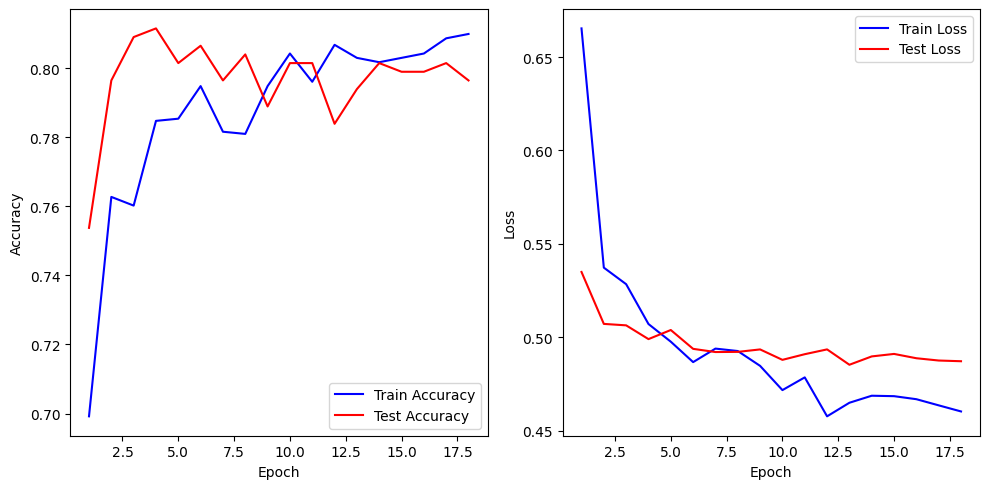

In [28]:
# learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, acc, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# adusting layout for better spacing
plt.tight_layout()

# display the figure
plt.show();

In [29]:
pred = DL_model.predict(x_test)
y_pred = (pred>0.5)
accuracy_score(y_test, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


0.7964824120603015

In [30]:
cr_DL = classification_report(y_test, y_pred)
print(cr_DL)

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       257
           1       0.80      0.57      0.66       141

    accuracy                           0.80       398
   macro avg       0.80      0.74      0.76       398
weighted avg       0.80      0.80      0.79       398



In [31]:
cm_DL = confusion_matrix(y_test, y_pred)
print(cm_DL)

[[237  20]
 [ 61  80]]


In [32]:
# Save the DL model
DL_model.save('DL_model.keras')
print("DL model saved successfully!")

DL model saved successfully!


<h2>Machine Learning vs Deep Learning</h2>

In [33]:
# Load models
ML_model = joblib.load('ML_model.pkl')
DL_model = load_model("DL_model.keras")

'''Make predictions (Age=26, Employment Type=1(private sector), GraduateOrNot=1(yes), AnnualIncome=1450000, FamilyMembers=5, ChronicDiseases=0(no),
FrequentFlyer=1(yes), EverTravelledAbroad= 1(yes)) '''
new_data = [[26, 1, 1, 1450000, 5, 0, 1, 1]]
new_data_scaled = sc.transform(new_data)

ML_prediction = ML_model.predict(new_data_scaled)
ML_prediction = 'Yes' if ML_prediction == 1 else 'No'

DL_prediction = DL_model.predict(new_data_scaled)
DL_prediction = 'Yes' if DL_prediction >= 0.5 else 'No'

print("ML prediction on whether the customer pruchase travel insurance:", ML_prediction)
print("DL prediction on whether the customer pruchase travel insurance:", DL_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
ML prediction on whether the customer pruchase travel insurance: Yes
DL prediction on whether the customer pruchase travel insurance: No


Deep learning keep predicting as 'No' might due to imbalance of the class in the dataset, can try class weight in future